<a href="https://colab.research.google.com/github/HarshalPawar88/Book-Recommendation-System/blob/main/Book_Recommendation_System_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction


---


During the last few decades, recommender systems have taken more and more place in our lives. From e-commerce to online advertisement, recommender systems are today unavoidable in our daily online journeys.

In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users. Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.

#Data Description


---



**The Book-Crossing dataset comprises 3 files.**

**● Users**

Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.

**● Books**

Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title,Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S,Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.

**● Ratings**
Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt


In [ ]:
df_books=pd.read_csv('/content/drive/MyDrive/Alma Better/Capstone_Project_2_BRS/data_book_recommendation/Books.csv')
df_ratings=pd.read_csv('/content/drive/MyDrive/Alma Better/Capstone_Project_2_BRS/data_book_recommendation/Ratings.csv')
df_user=pd.read_csv('/content/drive/MyDrive/Alma Better/Capstone_Project_2_BRS/data_book_recommendation/Users.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_books['Book-Author'].fillna('Unknown',inplace=True)

In [ ]:
# Define a function to combine to columns namely title and author
def change_title(str1,str2):
  '''Change the title of books'''
  str1 = str1 +" "+'by' +" "+str2
  return str1

In [ ]:
df_books.shape

(271360, 8)

In [ ]:
# Create a new column for title
df_books['new_title'] = df_books.apply(lambda x : change_title(x['Book-Title'],x['Book-Author']),axis = 1)

In [ ]:
# Get rid of duplications
df_books = df_books.drop_duplicates(subset='new_title',keep='first')

In [ ]:
df_books.shape

(251185, 9)

#Primary Inspection

In [ ]:
p=print

In [ ]:
df_merged = df_ratings.merge(df_books,how='inner',on='ISBN')
df_merged = df_merged.merge(df_user,how='inner',on='User-ID')


In [ ]:
df_merged.shape
df_merged['Title-Lenght'] = df_merged['Book-Title'].apply(len)
df_merged['Year-Of-Publication'] = pd.to_numeric(df_merged['Year-Of-Publication'], errors='coerce').fillna(2099, downcast = 'infer')

In [ ]:
df_merged.describe(include='all')

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,new_title,Location,Age,Title-Lenght
count,916933.00000,916933,916933.000000,916933,916933,916933.000000,916931,916933,916933,916929,916933,916933,671659.000000,916933.000000
unique,NaN,250075,NaN,241061,101587,NaN,16542,250074,250074,250071,250075,21418,NaN,NaN
top,NaN,0971880107,NaN,Wild Animus,Nora Roberts,NaN,Ballantine Books,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,Wild Animus by Rich Shapero,"toronto, ontario, canada",NaN,NaN
freq,NaN,2502,NaN,2502,7645,NaN,30011,2502,2502,2502,2502,13115,NaN,NaN
mean,140202.83165,NaN,2.825417,NaN,NaN,1968.353922,NaN,NaN,NaN,NaN,NaN,NaN,37.340037,34.243288
std,80804.41894,NaN,3.848183,NaN,NaN,230.251189,NaN,NaN,NaN,NaN,NaN,NaN,14.073900,23.618870
min,2.00000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
25%,69697.00000,NaN,0.000000,NaN,NaN,1991.000000,NaN,NaN,NaN,NaN,NaN,NaN,28.000000,16.000000
50%,140410.00000,NaN,0.000000,NaN,NaN,1997.000000,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,28.000000
75%,211426.00000,NaN,7.000000,NaN,NaN,2001.000000,NaN,NaN,NaN,NaN,NaN,NaN,45.000000,48.000000


In [ ]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 916933 entries, 0 to 916932
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              916933 non-null  int64  
 1   ISBN                 916933 non-null  object 
 2   Book-Rating          916933 non-null  int64  
 3   Book-Title           916933 non-null  object 
 4   Book-Author          916933 non-null  object 
 5   Year-Of-Publication  916933 non-null  int64  
 6   Publisher            916931 non-null  object 
 7   Image-URL-S          916933 non-null  object 
 8   Image-URL-M          916933 non-null  object 
 9   Image-URL-L          916929 non-null  object 
 10  new_title            916933 non-null  object 
 11  Location             916933 non-null  object 
 12  Age                  671659 non-null  float64
 13  Title-Lenght         916933 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 104.9+ MB


In [ ]:
df_merged.loc[df_merged['ISBN'].str.endswith('X')].head(3)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,new_title,Location,Age,Title-Lenght
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,Flesh Tones: A Novel by M. J. Rose,"tyler, texas, usa",NaN,20
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,Flesh Tones: A Novel by M. J. Rose,"cincinnati, ohio, usa",23.0,20
30,2313,080901548X,0,The Dark Child : The Autobiography of an Afric...,Camara Laye,1954,"Farrar, Straus and Giroux",http://images.amazon.com/images/P/080901548X.0...,http://images.amazon.com/images/P/080901548X.0...,http://images.amazon.com/images/P/080901548X.0...,The Dark Child : The Autobiography of an Afric...,"cincinnati, ohio, usa",23.0,52


## Conclusion: Some titles have same ISBN.

## **Unique Book Titles**

In [ ]:
len(df_merged['Book-Title'].unique())

241061

## **Unique ISBN**

In [ ]:
len(df_merged['ISBN'].unique())

250075

## **Unique Users**


In [ ]:
len(df_merged['User-ID'].unique())

85504

## **Publication Years**

In [ ]:
df_merged['Year-Of-Publication'].unique()

array([2002, 1994, 1996, 1998, 2001, 1987, 1984, 1997, 1970, 1978, 1993,
       1989, 1995, 1990, 1992, 1950, 1991, 1999, 1954, 1988, 2003, 2004,
       2000, 1983, 1985, 1982, 1956, 1979, 1986, 1975,    0, 1976, 1977,
       1980, 1981, 1974, 1957, 1958, 1960, 1963, 1969, 1972, 1961, 1971,
       1953, 1968, 1973, 1967, 1962, 1937, 1959, 1955, 2005, 1945, 1965,
       1964, 1927, 2020, 2050, 1920, 1966, 1952, 1930, 1940, 1942, 1947,
       1925, 1923, 2030, 1951, 1936, 1946, 1943, 2099, 1928, 1941, 2011,
       1948, 1901, 1932, 1939, 1944, 1938, 1902, 1929, 1900, 1911, 1949,
       1926, 1933, 1922, 1897, 2026, 1906, 1806, 1935, 2006, 2037, 1921,
       2024, 2038, 1924, 1378, 2008, 1934, 1909, 1931, 1904, 1917, 2012,
       1914, 1376, 1908, 1919])

# **Observation:-** We can clearly see that their are some noise values in the Year of Publication features :-
### 1. **String Noise Values -** such as 'DK Publishing Inc' and 'Gallimard.
### 2. **Integer Noise Values -** Since this data was collected in august 2004, so any year value greater than 2004 is a noise value.

In [ ]:
len(df_merged['Publisher'].unique())

16543

# **Preprocessing and Feature Engineering**

## 1. Feature Engineering on Location

In [ ]:
def get_country(x):
  return x.split(',')[-1]
  

In [ ]:
df_location = df_user.copy(deep=True)
df_location['country'] = df_user['Location'].apply(get_country)

In [ ]:
df_merged['Location'] = df_merged['Location'].apply(get_country)

1. Age

In [ ]:
# Create age groups using age column
bins = [-1,12,20,50,100]
labels = ['Kid','Teenager','Adult','Old']
df_merged['age_bins'] = pd.cut(x=df_merged['Age'], bins=bins,labels=labels)

##Capping Outlier



1. Age

In [ ]:
# Number of outliers
outliers = sum(df_merged['Age']>90)
print(outliers)

2872


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


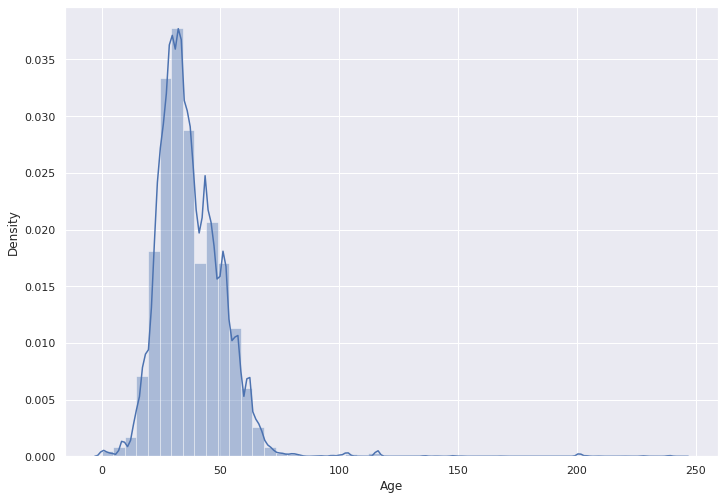

In [ ]:
# Plot Distribution of Age
sns.distplot(df_merged['Age'].dropna())
# Handling outliers by randomly replacing age >90 by values between 90 and 100
age2 = df_merged['Age'].copy()
random_age2 = np.random.randint(90,100,outliers)
age2[df_merged['Age']>90]=random_age2
df_merged['Age'] = age2

In [ ]:
# Calculating the mean vote across the whole df
C = df_merged['Rating-Mean'].mean()
C

2.8254419134221482

In [ ]:
# Calculating the minimum votes required to be listed in the top 5%
m = rating_count.quantile(.95)[0]
m

12.0

In [ ]:
# IMDB formula; source: https://tutorialedge.net/python/building-imdb-top-250-clone-pandas/
def weighted_rating(x, m=m, C=C):
    v = x['Rating-Count']
    R = x['Rating-Mean']

    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
df_merged_updated=df_merged[df_merged['Book-Rating']!=0]

In [ ]:
df_merged_updated.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Lenght,age_bins,Rating-Count,Rating-Mean
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,23,20,Adult,60,2.93
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,2,20,Kid,60,2.93


In [ ]:
df_merged_updated.shape

(340040, 14)

In [ ]:
# Create relevant sub-dataset
df_top_10 = df_merged_updated.copy().loc[df_merged_updated['Rating-Count'] >= m]
df_top_10.shape

(163365, 14)

In [ ]:
df_top_10['Score'] = df_top_10.apply(weighted_rating, axis=1)

# **2. Exploratory Data Analysis**

## Ratings Count

In [ ]:
rating_count=df_ratings['Book-Rating'].value_counts().reset_index().sort_values('Book-Rating',ascending=False)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Ratings Count')

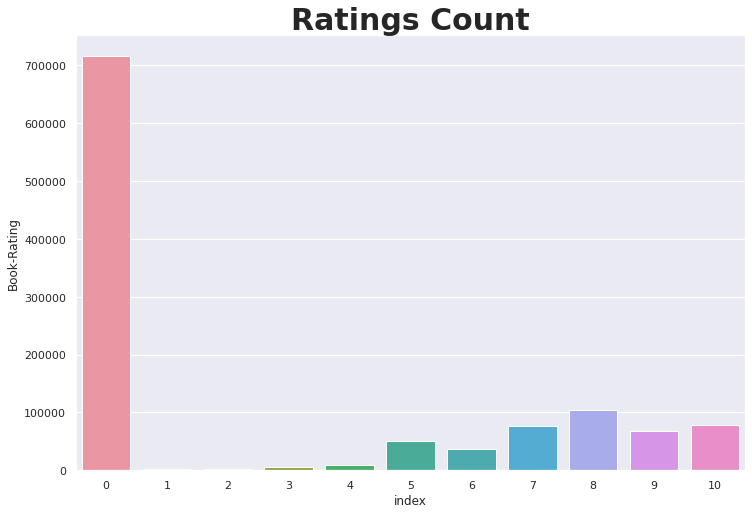

In [ ]:
plt.figure(figsize=(12,8))
ax=sns.barplot(rating_count['index'],rating_count['Book-Rating'])
ax.set_title('Ratings Count',fontsize=30,fontweight='bold')

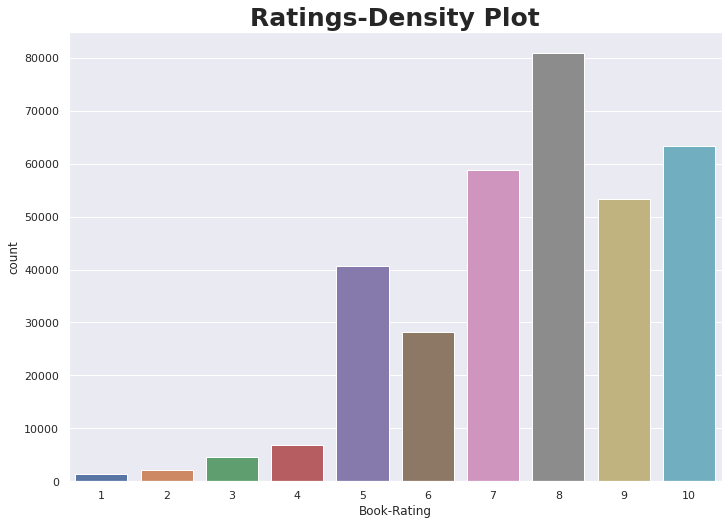

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
# df_merged_updated = df_merged_updated[df_merged['Book-Rating']!=0]
sns.countplot(x='Book-Rating', data=df_merged_updated).set_title('Ratings-Density Plot', weight='bold').set_fontsize('25')

## Author

In [ ]:
auth_rating=df_merged.groupby(['Book-Author'])['Book-Rating'].count().sort_values(ascending=False).reset_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Author V/S Ratings')

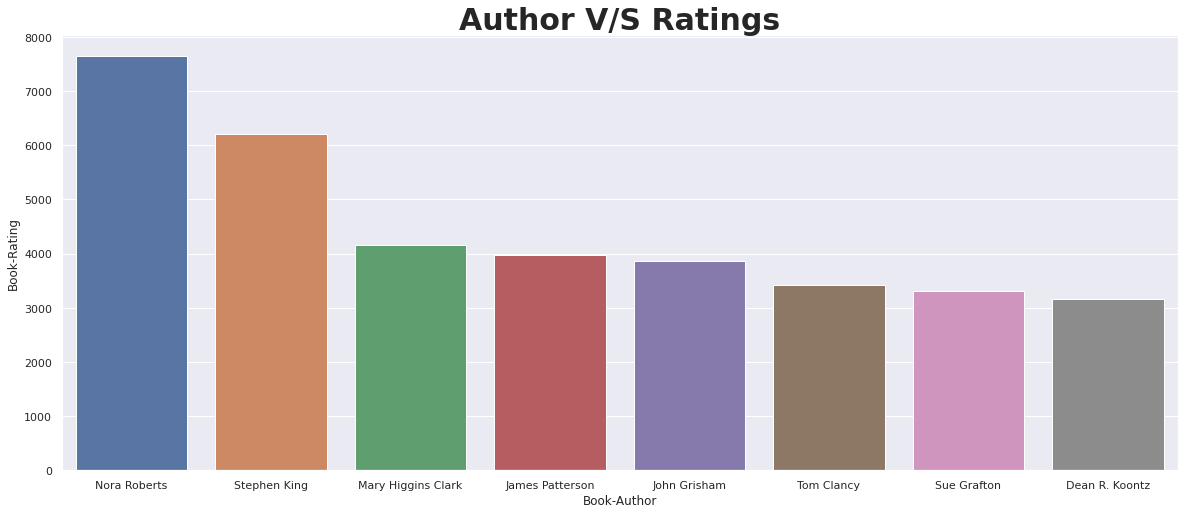

In [ ]:
plt.figure(figsize=(20,8))
ax=sns.barplot(auth_rating[auth_rating['Book-Rating']>3000]['Book-Author'],auth_rating[auth_rating['Book-Rating']>3000]['Book-Rating'])
ax.set_title('Author V/S Ratings', fontsize=30,fontweight='bold')


In [ ]:
book_rating=df_merged.groupby(['Book-Title'])['Book-Rating'].count().sort_values(ascending=False).reset_index()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000.]),
 <a list of 7 Text major ticklabel objects>)

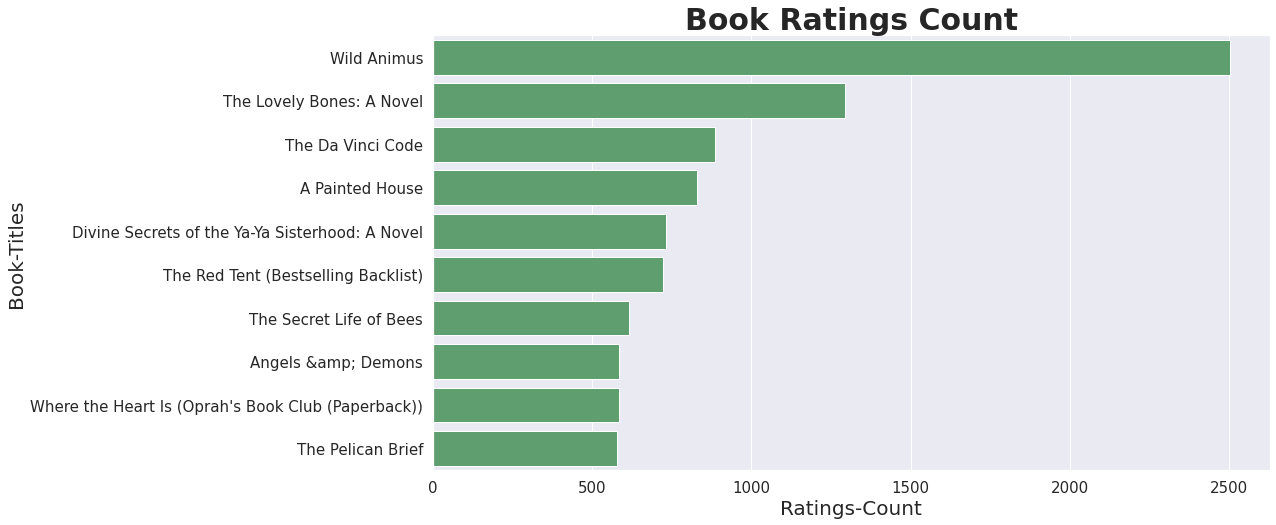

In [ ]:
plt.figure(figsize=(15,8))
ax=sns.barplot(book_rating['Book-Rating'][:10],book_rating['Book-Title'][:10],color='g')
ax.set_title('Book Ratings Count', fontsize=30,fontweight='bold')
ax.set_xlabel('Ratings-Count',fontsize=20)
ax.set_ylabel('Book-Titles',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

## Location

In [ ]:
#Identifying what % of customers are coming from different countries
df_location = pd.DataFrame(df_location.country.value_counts(normalize=True)).reset_index()
df_location.columns = ['countries','value_counts']

#Labeling countries with low customer % as other
df_location['countries'] = df_location.apply(lambda x: 'other' if (x['value_counts'] < 0.01 or x['countries'] == '') else x['countries'],axis=1)

#Grouping the customer % from 'other' countries 
df_location = df_location.groupby('countries')['value_counts'].sum().reset_index()

In [ ]:
#Every country has now just one occurance
df_location.countries.value_counts()

 new zealand       1
 netherlands       1
 united kingdom    1
 france            1
 portugal          1
 italy             1
 australia         1
 canada            1
 usa               1
other              1
 germany           1
 spain             1
Name: countries, dtype: int64

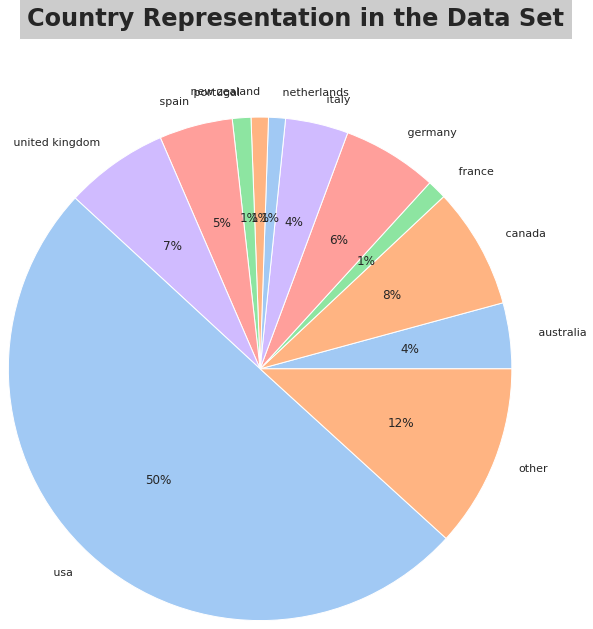

In [ ]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.title("Country Representation in the Data Set",bbox={'facecolor':'0.8', 'pad':8},fontsize=24, fontdict={"weight": "bold"},y=1.25,x=0.578)
f = plt.pie(df_location['value_counts'], labels = df_location['countries'], colors = colors, autopct='%.0f%%',radius=1.4)

# **Insight**: Most customers are from United states of America, followd by Canada, United Kingdom and Germany

*Countries with less than 1% customers are labeled as other